# 1，数据集准备


数据集来自kaggle的dog vs cat主页（https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data）


In [1]:
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import os
import h5py

data_path = './'
train_dir_name = 'train'
test_dir_name = 'test'

## check if the train and  test data is exist
if not isdir(data_path + train_dir_name):
    if not isfile(data_path + train_dir_name + '.zip'):
        print ("Please download train.zip from kaggle!")
        assert(False)
    else:
        with zipfile.ZipFile(data_path + train_dir_name + '.zip') as azip:
            print ("Now to extract %s " % (data_path + train_dir_name + '.zip'))
            azip.extractall()
    
if not isdir(data_path + test_dir_name):
    if not isfile(data_path + test_dir_name + '.zip'):
        print ("Please download test1.zip from kaggle!")
        assert(False)
    else:
        with zipfile.ZipFile(data_path + test_dir_name + '.zip') as azip:
            print ("Now to extract %s " % (data_path + test_dir_name + '.zip'))
            azip.extractall()
print ("Data is ready!")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Data is ready!


## 1.1，将猫狗训练数据分开存放

为了尽快实现想法，我打算采用Keras平台，因为Keras已经包含了众多知名的模型，并且可以很轻易地加载与训练权重。而且Keras也提供了很方便的工具（image generator）来帮助我们直接从硬盘加载图片到模型，这样不但减少了代码量，而且利用Keras自带的程序能够极大减少内存的浪费（相比于手动一次性加载到内存）。但是image generator需要图片已经根据类别放入不同的文件夹。所以接下来的事情就是将训练和测试样本按照类别放入不同的文件夹。采用软链接的方式可以节约硬盘和时间。

In [2]:
train_dir = data_path + train_dir_name
test_dir = data_path + test_dir_name

## get all train filenames and test filenames
train_filenames = os.listdir(train_dir)
test_filenames = os.listdir(test_dir)

## get all dogs and cats
cat_names = filter(lambda x:x[:3] == 'cat', train_filenames)
dog_names = filter(lambda x:x[:3] == 'dog', train_filenames)

现在已经获得了文件名，现在需要另外建立一个文件夹，用于存储分开的猫狗图片。为了节省空间，这里采用建立软链接的方式来分开存储猫狗图片。

In [3]:
## check if we did that
test_link_path = './test_link'
test_link_data = './test_link/data'

train_link_path = './train_link'
train_link_cat = './train_link/cat'
train_link_dog = './train_link/dog'

if not isdir(test_link_path):
    print ("Now to build %s!" % (test_link_path))
    os.makedirs(test_link_path)
    os.symlink('../' + test_dir_name, test_link_data)
    
if not isdir(train_link_path):
    print ("Now to build %s!" % (train_link_path))
    os.makedirs(train_link_cat)
    os.makedirs(train_link_dog)
    ## create link for the image
    for file in cat_names:
        os.symlink('../../' + train_dir_name+'/'+file, train_link_cat+'/'+file)
    for file in dog_names:
        os.symlink('../../' + train_dir_name+'/'+file, train_link_dog+'/'+file)

print ("Build all linkage complete!")

Build all linkage complete!


# 2, 方案1--单个模型

首先我想到的第一个方案就是单个模型，在计算机视觉领域，有许多已经被证明了非常好用的模型，比如inception，resnet等，所以我接下来就是依次尝试各个模型，看看实际的效果怎么样？能否达到毕业项目的要求？并且我会预训练模型来进行训练，而不是从头训练，因为这些模型都已经在庞大的分类数据集中进行了训练，已经学习了足够的用于常用物体分类的‘知识’，因为图像的基本‘知识’是可以通用的，所以我采用迁移学习来对模型进行‘微调’，而不是从头学起。我打算采用inceptionv3,resnet-50,xception这三个模型来进行尝试。

## 2.1 resnet-50

初步采用的模型是ResNet-50，所以我们就需要按照该模型的要求来对图片进行预处理。
现在我们需要载入预训练的ResNet-50模型，并且，由于ResNet-50模型的输出是1000维的向量，而我们的功能是二分类，所以只需要输出单一的概率即可，所以需要替换掉原始的输出层换成我们的sigmoid激活函数，include_top=False就不会加载原模型的全连接层部分。

In [4]:
from keras.applications import resnet50

## resNet-50 do not need preprocessing, so the resNet_input_shape is not neccessary
resNet_input_shape = (224,224,3)

res_x = Input(shape=resNet_input_shape)
res_x = Lambda(resnet50.preprocess_input)(res_x)
res_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=res_x, input_shape=resNet_input_shape)

print (res_model.output)

Tensor("avg_pool/AvgPool:0", shape=(?, 1, 1, 2048), dtype=float32)


由于我们采用的预训练模型，暂时只是在ResNet-50上微调，不会对全连接层以外的其它层进行训练。所以如果每次都从上面的模型的输入端进行输入的话会产生很多重复的计算，显得不那么高效。那么这里有一个技巧，可以先把resnet-50模型的全连接层以前的输出向量（传说中的bottleneck features，以下均称为特征向量）预先计算并保存起来，由于只需要训练之后的全连接层，所以，将这些保存的特征向量作为样本，当做之后的全连接层的训练的输入就好了。

In [5]:
vec_dir_name = "vect/"
resnet_50_vec_name = 'resnet-50.h5'
vec_dir_path = data_path + "vect"
resnet_50_vec_path = data_path + vec_dir_name + resnet_50_vec_name
print (vec_dir_path)
if not isdir(vec_dir_path):
    os.makedirs(vec_dir_path)
    print ("Make vector dir:%s" % (vec_dir_path))
    
"""
check if the resnet-50 vector file is exist
"""
if not isfile(resnet_50_vec_path):
    with h5py.File(resnet_50_vec_path, 'w') as f:
        print ("creating vector!!")
        out = GlobalAveragePooling2D()(res_model.output)
        res_vec_model = Model(inputs=res_model.input, outputs=out)
        
        ## save vector
        gen = ImageDataGenerator()
        test_gen = ImageDataGenerator()
        """
        classes = ['cat', 'dog'] -- cat is 0, dog is 1, so we need write this
        class_mode = None -- i will not use like 'fit_fitgenerator', so i do not need labels
        shuffle = False -- it is unneccssary
        batch_size = 64 
        """
        image_size = (224,224)
        train_generator = gen.flow_from_directory(train_link_path, image_size, color_mode='rgb', \
                                                  classes=['cat', 'dog'], class_mode=None, shuffle=False, batch_size=64)
        test_generator = test_gen.flow_from_directory(test_link_path, image_size, color_mode='rgb', \
                                                  class_mode=None, shuffle=False, batch_size=64)        
        """
        steps = None, by default, the steps = len(generator)
        """
        vector = res_vec_model.predict_generator(train_generator)
        test_vector = res_vec_model.predict_generator(test_generator)
        
        f.create_dataset('x_train', data=vector)
        f.create_dataset("y_train", data=train_generator.classes)
        f.create_dataset("test", data=test_vector)


./vect


现在直接读取保存的特征向量进行训练，参数如下，优化器采用Adam，学习速率采用默认的0.001，batch size为32，先训练20epoch看看结果。

In [6]:
import numpy as np
from sklearn.utils import shuffle


with h5py.File(resnet_50_vec_path, 'r') as f:
    x_train = np.array(f['x_train'])
    y_train = np.array(f['y_train'])
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    
input_tensor = Input(shape=(2048,))
x = Dropout(0.4)(input_tensor)
x = Dense(1, activation='sigmoid', name='res_dense_1')(x)

res_top_model = Model(inputs=input_tensor, outputs=x)

res_top_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = res_top_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 17s 848us/step - loss: 0.0758 - acc: 0.9722 - val_loss: 0.0370 - val_acc: 0.9864
Epoch 2/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.0422 - acc: 0.9858 - val_loss: 0.0324 - val_acc: 0.9882
Epoch 3/20
20000/20000 [==============================] - 3s 129us/step - loss: 0.0370 - acc: 0.9865 - val_loss: 0.0331 - val_acc: 0.9882
Epoch 4/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.0352 - acc: 0.9870 - val_loss: 0.0300 - val_acc: 0.9878
Epoch 5/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.0316 - acc: 0.9886 - val_loss: 0.0318 - val_acc: 0.9880
Epoch 6/20
20000/20000 [==============================] - 3s 128us/step - loss: 0.0335 - acc: 0.9879 - val_loss: 0.0276 - val_acc: 0.9902
Epoch 7/20
20000/20000 [==============================] - 3s 126us/step - loss: 0.0307 - acc: 0.9897 - val_loss: 0.0312 - 

上面的结果看起来还不错，待会儿再在测试集上得出结果提交到kaggle。其实在得到这个结果之前犯了一个错误，就是从文件中读取出来x_train和y_train之后，没有对样本进行shuffle。导致验证集的loss在0.2到0.7不断地跳动，我刚开始还以为只是模型的结构引起的过拟合，所以修改了dropout的rate，将其变大，也就是丢弃的几率变大。而且还在输出层对参数加了一个L2的正则化。但是几乎没有效果。所以我就意识到，可能不是模型的问题。然后在群上看他们聊天聊到shuffle，我恍然大悟，原来是我读出来的时候没有进行shuffle，现在就好了。

In [7]:
import matplotlib.pyplot as plt

def show_loss(hist, title='loss'):
    # show the training and validation loss
    plt.plot(hist.history['val_loss'], label="validation loss")
    plt.plot(hist.history['loss'], label="train loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()
def show_acc(hist, title='accuracy'):
    # show the training and validation loss
    plt.plot(hist.history['val_acc'], label="validation accuracy")
    plt.plot(hist.history['acc'], label="train accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()

show_loss(hist)
show_acc(hist)

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

模型训练完了之后，应该对测试集进行预测，并且声称csv格式的结果文件提交kaggle，从而得到模型的得分。其实文档的格式很简单，就是对测试集的每张图片的预测结果（也就是这张图片是狗的概率，注意不是0或者1哟！是类似0.99  0.11之类的概率值！），我写了一个专门的接口函数来完成预测以及结果文件的生成

In [8]:
import pandas as pd

def get_test_result(model_obj, test_vec_path, image_size, model_name=""):
    with h5py.File(test_vec_path, 'r') as f:
        x_test = np.array(f['test'])

    pred_test = model_obj.predict(x_test)
    pred_test = pred_test.clip(min=0.005, max=0.995)
    
    df = pd.read_csv("sampleSubmission.csv")

    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory(test_link_path, image_size, color_mode='rgb',
                                             shuffle=False, batch_size=64, class_mode=None)

    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        #df.set_value(index-1, 'label', y_pred[i])
        df.loc[index-1, 'label'] = pred_test[i]
    
    df.to_csv('%s.csv' % (model_name), index=None)
    print ('test result file %s.csv generated!' % (model_name))
    df.head(10)

get_test_result(res_top_model, resnet_50_vec_path, (224, 224), model_name="resnet-50")

Found 12500 images belonging to 1 classes.
test result file resnet-50.csv generated!


这次提交了kaggle之后，loss为0.053。resnet-50模型先暂时不试了。先把模型参数和参数保存起来。由于是预训练模型，所以就不需要保存resnet-50部分，只保存添加的输出层参数就好了。

In [9]:
res_top_model.save('resnet-50.h5')

## 2.2 inceptionv3

接下尝试的是inceptionv3模型。因为以后还会尝试更多的模型，所以这里需要写一个通用的函数，而不是像之前resnet那样很分散。下面这个函数用于各种模型的特征向量的提取。

In [10]:
from keras.layers import Input
from keras.layers.core import Lambda

def model_vector_catch(MODEL, image_size, file_name, preprocessing=None):
    vec_dir = 'vect/'

    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    if preprocessing:
        ## check if need preprocessing
        input_tensor = Lambda(preprocessing)(input_tensor)
    model_no_top = MODEL(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(image_size[0], image_size[1], 3))
    ## flatten the output shape and generate model
    out = GlobalAveragePooling2D()(model_no_top.output)
    new_model = Model(inputs=model_no_top.input, outputs=out)
    
    ## get iamge generator
    gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    """
    classes = ['cat', 'dog'] -- cat is 0, dog is 1, so we need write this
    class_mode = None -- i will not use like 'fit_fitgenerator', so i do not need labels
    shuffle = False -- it is unneccssary
    batch_size = 64 
    """
    train_generator = gen.flow_from_directory(train_link_path, image_size, color_mode='rgb', \
                                              classes=['cat', 'dog'], class_mode=None, shuffle=False, batch_size=64)
    test_generator = test_gen.flow_from_directory(test_link_path, image_size, color_mode='rgb', \
                                          class_mode=None, shuffle=False, batch_size=64)
    """
    steps = None, by default, the steps = len(generator)
    """
    train_vector = new_model.predict_generator(train_generator)
    test_vector = new_model.predict_generator(test_generator)
    
    with h5py.File(vec_dir + ("%s.h5" % (file_name)), 'w') as f: 
        f.create_dataset('x_train', data=train_vector)
        f.create_dataset("y_train", data=train_generator.classes)
        f.create_dataset("test", data=test_vector)
    print ("Model %s vector cached complete!" % (file_name))

In [11]:
from keras.applications import inception_v3

inceptionv3_vec_path = 'vect/inceptionv3.h5'

if not isfile(inceptionv3_vec_path):
    model_vector_catch(inception_v3.InceptionV3, (299, 299), 'inceptionv3', inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Model inceptionv3 vector cached complete!


同样，我们先搭建模型，然后进行迁移学习。由于inceptionv3在全连接层之前的输出维度是(?, 1, 1, 2048)，所以新搭建的模型的输入维度是2048.

inception v3论文上说其训练时候采用的是RMSProp，初始学习速率为0.045，rho=0.9, epsilon=1.0（确定吗？但是论文上是这样写的），decay采用指数衰减，每两个epoch衰减一次。指数衰减的公式如下：decayed_learning_rate = lr_base * decay_rate ^ (global_step / decay_steps)  

但是我有一个问题，论文中给出的训练的建议是基于ImageNet的训练集，并且作者是训练整体的模型，但是现在是在猫狗数据上进行训练，而且并没有对整体的模型进行训练，那我们是否应该采用论文中的建议的训练方式，下面尝试一下就知道了。

In [12]:
import numpy as np
from sklearn.utils import shuffle

with h5py.File(inceptionv3_vec_path, 'r') as f:
    x_train = np.array(f['x_train'])
    y_train = np.array(f['y_train'])
    x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [28]:
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
import math
    
input_tensor = Input(shape=(2048,))
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', name='inc_dense_1')(x)

inceptionv3_model = Model(inputs=input_tensor, outputs=x)

#optimizer
#lr_base = 0.045
lr_base = 0.0002
decay_rate = 0.94
decay_steps = 2
#opt = RMSprop(lr=lr_base, rho=0.9, epsilon=1.0)
opt = RMSprop(lr=lr_base, rho=0.9)

# exponential rate decay:decayed_learning_rate = lr_base * decay_rate ^ (global_step / decay_steps)
def lr_scheduler(epoch):
    # calculate the new learning rate according to epoch number
    lr = lr_base * ((decay_rate)**math.floor(epoch/decay_steps))
    print ("Epoch %d , new lr==%f" % (epoch, lr))    
    
    return lr

scheduler = LearningRateScheduler(lr_scheduler)
inceptionv3_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

hist = inceptionv3_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2, callbacks=[scheduler])

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
Epoch 0 , new lr==0.000200
20000/20000 [==============================] - 6s 286us/step - loss: 0.1802 - acc: 0.9615 - val_loss: 0.0443 - val_acc: 0.9910
Epoch 2/30
Epoch 1 , new lr==0.000200
20000/20000 [==============================] - 2s 124us/step - loss: 0.0378 - acc: 0.9918 - val_loss: 0.0289 - val_acc: 0.9920
Epoch 3/30
Epoch 2 , new lr==0.000188
20000/20000 [==============================] - 3s 126us/step - loss: 0.0293 - acc: 0.9924 - val_loss: 0.0251 - val_acc: 0.9922
Epoch 4/30
Epoch 3 , new lr==0.000188
20000/20000 [==============================] - 2s 124us/step - loss: 0.0256 - acc: 0.9924 - val_loss: 0.0233 - val_acc: 0.9928
Epoch 5/30
Epoch 4 , new lr==0.000177
20000/20000 [==============================] - 2s 122us/step - loss: 0.0241 - acc: 0.9931 - val_loss: 0.0220 - val_acc: 0.9934
Epoch 6/30
Epoch 5 , new lr==0.000177
20000/20000 [==============================] - 2s 124us/step - loss: 0.0242 - acc: 0.992

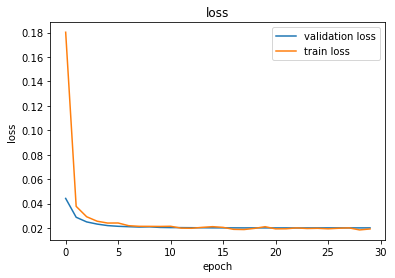

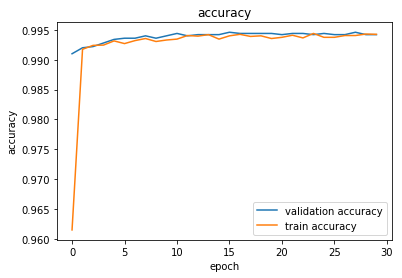

In [29]:
show_loss(hist)
show_acc(hist)

可以看到，如果按照论文上的训练方法训练效果还是很不错的，现在就来看看该模型的评分吧！

In [30]:
get_test_result(inceptionv3_model, inceptionv3_vec_path, (299, 299), model_name="inceptionv3")

Found 12500 images belonging to 1 classes.
test result file inceptionv3.csv generated!


提交kaggle之后，发现获得的分数为0.04074，在leaderboard中可以排名到第17名，也就是在2%以内。同样，我们保存该模型与权重。

In [31]:
inceptionv3_model.save('model_inceptionv3.h5')

## 2.3 xception
接下来我将尝试xception模型，出了预处理函数和图片上输出尺寸需要改动外，其他均和上述过程一致

In [32]:
from keras.applications import xception

xception_vec_path = 'vect/xception.h5'

if not isfile(xception_vec_path):
    model_vector_catch(xception.Xception, (299, 299), 'xception', xception.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Model xception vector cached complete!


In [33]:
with h5py.File(xception_vec_path, 'r') as f:
    x_train = np.array(f['x_train'])
    y_train = np.array(f['y_train'])
    x_train, y_train = shuffle(x_train, y_train, random_state=0)

对于训练方式，我还是选择与inceptionv3一样的训练方式

In [34]:
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
import math
    
input_tensor = Input(shape=(2048,))
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', name='xce_dense_1')(x)

xception_model = Model(inputs=input_tensor, outputs=x)

#optimizer
#lr_base = 0.045
lr_base = 0.0002
decay_rate = 0.94
decay_steps = 2
#opt = RMSprop(lr=lr_base, rho=0.9, epsilon=1.0)
opt = RMSprop(lr=lr_base, rho=0.9)

# exponential rate decay:decayed_learning_rate = lr_base * decay_rate ^ (global_step / decay_steps)
def lr_scheduler(epoch):
    # calculate the new learning rate according to epoch number
    lr = lr_base * ((decay_rate)**math.floor(epoch/decay_steps))
    print ("Epoch %d , new lr==%f" % (epoch, lr))    
    
    return lr

scheduler = LearningRateScheduler(lr_scheduler)
xception_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

hist = xception_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2, callbacks=[scheduler])

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
Epoch 0 , new lr==0.000200
20000/20000 [==============================] - 7s 337us/step - loss: 0.1538 - acc: 0.9786 - val_loss: 0.0441 - val_acc: 0.9902
Epoch 2/30
Epoch 1 , new lr==0.000200
20000/20000 [==============================] - 3s 136us/step - loss: 0.0373 - acc: 0.9914 - val_loss: 0.0298 - val_acc: 0.9910
Epoch 3/30
Epoch 2 , new lr==0.000188
20000/20000 [==============================] - 3s 131us/step - loss: 0.0296 - acc: 0.9920 - val_loss: 0.0250 - val_acc: 0.9922
Epoch 4/30
Epoch 3 , new lr==0.000188
20000/20000 [==============================] - 3s 130us/step - loss: 0.0260 - acc: 0.9926 - val_loss: 0.0231 - val_acc: 0.9928
Epoch 5/30
Epoch 4 , new lr==0.000177
20000/20000 [==============================] - 3s 132us/step - loss: 0.0243 - acc: 0.9927 - val_loss: 0.0221 - val_acc: 0.9932
Epoch 6/30
Epoch 5 , new lr==0.000177
20000/20000 [==============================] - 3s 130us/step - loss: 0.0236 - acc: 0.992

可视化fit过程

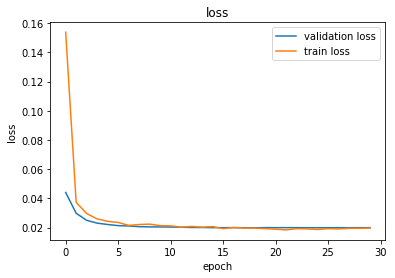

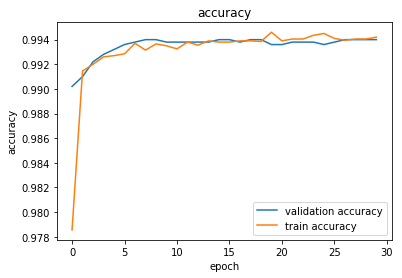

In [35]:
show_loss(hist)
show_acc(hist)

In [36]:
get_test_result(xception_model, xception_vec_path, (299, 299), model_name="xception")

Found 12500 images belonging to 1 classes.
test result file xception.csv generated!


xception在测试集上的分数是0.04138，结果和inceptionv3差不多

# 3 模型的集成

我们知道，在机器学习中有一种技巧叫做集成学习，不知道其是否适用于深度学习，集成学习的思想就是三个臭皮匠顶个诸葛亮，让多个模型来进行投票，遵循少数服从多数的原则来产生预测结果，可以使预测结果更加平滑，准确，坏处就是可能会增加预测的时间，但是既然kaggle没有提到有模型预测时间的要求，那么我们就可以尝试一些集成学习。

在这里我简单地尝试一下uniform blending的集成方式，然后采用取三个模型的输出值的平均值作为集成的最终输出（而不是所谓的‘投票’，因为kaggle需要输出概率值而不是投票结果）。

注意：uniform blending集成方法的假设是我们的三个基准模型本身拥有diversity，这样才会有好的结果。我不清楚我的这三个模型知否符合这样的要求。而且集成方法的效果总是会随着基准模型的数量的增多而变好，所以我也不清楚3个模型到底够不够。既然不懂，就尝试嘛！

创建集成模型，由于网络结构比较简答，就没有必要像之前的bottleneck features那样预先保存向量了，直接将之前训练好的三个模型的输出层合并求平均就好了。

In [63]:
 from keras.layers import Average

## resnet_50
resnet50_input = res_top_model.input
resnet50_output = res_top_model.output

##inception_v3
inceptionv3_input = inceptionv3_model.input
inceptionv3_output = inceptionv3_model.output

##xception
xception_input = xception_model.input
xception_output = xception_model.output

agg_out = Average()([resnet50_output, inceptionv3_output, xception_output])

agg_model = Model(inputs=[resnet50_input, inceptionv3_input, xception_input], outputs=agg_out)

定义一个函数，方便获取各个不同基准模型的bottleneck features。

In [64]:
def get_bottleneck_features(path):
    ## get bottleneck features
    with h5py.File(path, 'r') as f:
        x_train = np.array(f['x_train'])
        y_train = np.array(f['y_train'])
        x_test = np.array(f['test'])
        return x_train,  y_train, x_test

现在再获取各个基准模型的bottleneck features，作为集成模型的输入

In [65]:
## resnet 50
res_x_train, res_y_train, res_test = get_bottleneck_features(resnet_50_vec_path)

## inception v3
inc_x_train, inc_y_train, inc_test = get_bottleneck_features(inceptionv3_vec_path)

## xception
xce_x_train, xce_y_train, xce_test = get_bottleneck_features(xception_vec_path)

因为没有任何参数需要优化，所以无需训练，我们现在evaluation来看看结果如何

In [66]:
agg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
tmp = agg_model.get_layer(name='res_dense_1')
print (tmp.get_weights())

[array([[ 0.02872438],
       [ 0.10601974],
       [ 0.10614847],
       ...,
       [ 0.13479488],
       [-0.00721408],
       [ 0.21296887]], dtype=float32), array([0.13192685], dtype=float32)]


In [68]:
agg_model.evaluate([res_x_train, inc_x_train, xce_x_train], res_y_train, batch_size=32)

25000/25000 [==============================] - 3s 119us/step


[0.21644297064736487, 0.98908]

现在如果我单纯地做集成，而不训练的话，效果并不好，可以看到loss为0.216，并不理想。所以现在我打算训练一下。然后看看效果。

In [70]:
hist = agg_model.fit([res_x_train, inc_x_train, xce_x_train], res_y_train, batch_size=32, epochs=10, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 189us/step - loss: 0.0111 - acc: 0.9968 - val_loss: 0.0165 - val_acc: 0.9950
Epoch 2/10
20000/20000 [==============================] - 4s 189us/step - loss: 0.0117 - acc: 0.9970 - val_loss: 0.0242 - val_acc: 0.9932
Epoch 3/10
20000/20000 [==============================] - 4s 189us/step - loss: 0.0114 - acc: 0.9970 - val_loss: 0.0198 - val_acc: 0.9938
Epoch 4/10
20000/20000 [==============================] - 4s 187us/step - loss: 0.0120 - acc: 0.9969 - val_loss: 0.0171 - val_acc: 0.9948
Epoch 5/10
20000/20000 [==============================] - 4s 183us/step - loss: 0.0109 - acc: 0.9970 - val_loss: 0.0226 - val_acc: 0.9934
Epoch 6/10
20000/20000 [==============================] - 4s 190us/step - loss: 0.0113 - acc: 0.9972 - val_loss: 0.0185 - val_acc: 0.9946
Epoch 7/10
20000/20000 [==============================] - 4s 189us/step - loss: 0.0108 - acc: 0.9973 - val_loss: 0.0199 - v

可以看到效果还是不错的，只不过是验证集有一些震荡，可能和学习速率有关系，所以现在我采用学习速率衰减的方法。

In [ ]:


agg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])